In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import ExtraTreesClassifier as ExTC
#from pprint import pprint
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
R2 = pd.read_csv('./surrogate_performance/benchmark_test_R^2.csv', index_col=0)
features = pd.read_csv('./features/benchmark_train.csv', index_col=0)

cv_max = pd.read_csv('./surrogate_performance/benchmarkCV-score-max.csv', index_col=0)
cv_mean = pd.read_csv('./surrogate_performance/benchmarkCV-score-mean.csv', index_col=0)

R2_on_optimal = pd.read_csv('./surrogate_performance/benchmark_optimal_R^2.csv', index_col=0)
MSE_on_optimal = pd.read_csv('./surrogate_performance/benchmark_optimal_MSE.csv', index_col=0)

# Drop NANs
features.dropna(axis = 1, inplace=True)

# Drop columns with only one unique value
cols = features.select_dtypes([np.number]).columns
std = features[cols].std()
cols_to_drop = std[std==0].index
features = features.drop(cols_to_drop, axis=1)

# Drop columns with inf
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(axis = 1, inplace=True)

# Calculating Loss and Targets. Target is the modelling method with lowest loss.
loss = -R2.sub(R2.max(axis=1), axis=0)
targets = loss.idxmin(axis=1)

# Getting data that is avalable in both targets and features
features_available_for = targets.index.intersection(features.index)
targets = targets.loc[features_available_for]
######################
loss = loss.loc[features_available_for]

# Doing the same for cv_max and cv_mean

cv_max = cv_max.loc[features_available_for]
cv_mean = cv_mean.loc[features_available_for]
cv_mean_best = cv_mean.idxmax(axis=1)
cv_max_best = cv_max.idxmax(axis=1)

#Same for optimal sets
R2_on_optimal = R2_on_optimal.loc[features_available_for]
MSE_on_optimal = MSE_on_optimal.loc[features_available_for]
loss_on_optimal = -R2_on_optimal.sub(R2_on_optimal.max(axis=1), axis=0)

In [3]:
selector = ExTC()
selector.fit(features.values, targets.values)

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [4]:
predicted_targets = selector.predict(features)
predicted_targets = pd.DataFrame(predicted_targets, index=features.index, columns=['Prediction'])

In [5]:
loss_prediction = pd.DataFrame(columns=['Prediction'], index=features.index, dtype=float)
for comp_id in features.index:
    loss_prediction['Prediction'].at[comp_id] = loss_on_optimal[predicted_targets.loc[comp_id]].loc[comp_id]
    
loss_predictionCVmax = pd.DataFrame(columns=['CVmax'], index=features.index, dtype=float)
for comp_id in features.index:
    loss_predictionCVmax['CVmax'].at[comp_id] = loss_on_optimal[cv_max_best.loc[comp_id]].loc[comp_id]
    
loss_predictionCVmean = pd.DataFrame(columns=['CVmean'], index=features.index, dtype=float)
for comp_id in features.index:
    loss_predictionCVmean['CVmean'].at[comp_id] = loss_on_optimal[cv_mean_best.loc[comp_id]].loc[comp_id]

In [6]:
# To get the problem characteristics out of the filename:

columns = {'ProblemName':0, 'num_var':1, 'num_samples':2, 'distribution':3}

characteristics = pd.DataFrame(index=loss_prediction.index, columns=columns)
for index in characteristics.index:
    for column in columns:
        characteristics[column][index] = index.split('.')[0].split('_')[columns[column]]
characteristics['num_var'] = characteristics['num_var'].astype(int)
characteristics['num_samples'] = characteristics['num_samples'].astype(int)

In [7]:
performance = characteristics.join(loss_prediction)
performance = performance.join(loss_predictionCVmax)
performance = performance.join(loss_predictionCVmean)

<IPython.core.display.Javascript object>


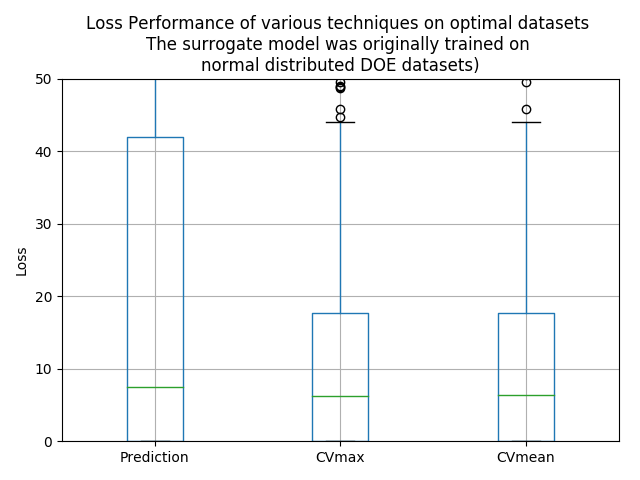

In [110]:
performance[performance['distribution']=='normal'][['Prediction', 'CVmax', 'CVmean']].boxplot()
plt.ylim([0,50])
plt.title('Loss Performance of various techniques on optimal datasets \n'
          'The surrogate model was originally trained on \n'
          'normal distributed DOE datasets)')
plt.ylabel('Loss')
plt.tight_layout()

In [22]:
performance.describe()

,num_var,num_samples,Prediction,CVmax,CVmean
count,2714.000000,2714.000000,2.714000e+03,2.714000e+03,2.714000e+03
mean,16.741341,684.524687,1.439211e+06,1.434580e+06,1.430797e+06
std,8.532508,515.307529,5.946546e+06,5.945356e+06,5.928122e+06
min,6.000000,100.000000,-0.000000e+00,-0.000000e+00,-0.000000e+00
25%,10.000000,300.000000,7.769468e-02,5.117813e-02,5.282617e-02
50%,16.000000,600.000000,5.183634e+00,4.642048e+00,4.686296e+00
75%,20.000000,975.000000,3.004536e+01,1.774946e+01,1.766380e+01
max,30.000000,2000.000000,5.253085e+07,5.283371e+07,5.253085e+07


<IPython.core.display.Javascript object>


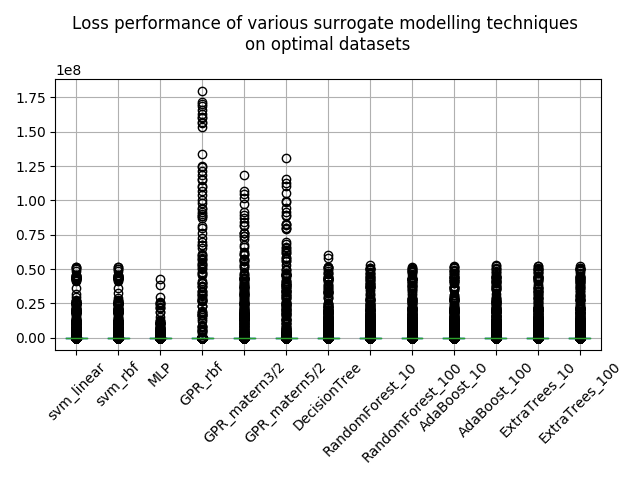

In [115]:
loss_on_optimal.boxplot()
plt.xticks(rotation=45)
plt.title("Loss performance of various surrogate modelling techniques \non optimal datasets\n")
plt.tight_layout()

In [30]:
loss_on_optimal.describe()

,svm_linear,svm_rbf,MLP,GPR_rbf,GPR_matern3/2,GPR_matern5/2,DecisionTree,RandomForest_10,RandomForest_100,AdaBoost_10,AdaBoost_100,ExtraTrees_10,ExtraTrees_100
count,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03
mean,1.272862e+06,1.275843e+06,2.939350e+05,2.347354e+06,2.004131e+06,1.889432e+06,1.424026e+06,1.415397e+06,1.406451e+06,1.445360e+06,1.414299e+06,1.448184e+06,1.452570e+06
std,5.530698e+06,5.539103e+06,2.117774e+06,1.520361e+07,9.765987e+06,1.028175e+07,5.936327e+06,5.870825e+06,5.831173e+06,5.934263e+06,5.846156e+06,5.981956e+06,5.983045e+06
min,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
25%,2.569527e-01,3.472579e-01,1.750200e+00,1.929708e-01,2.939155e-02,3.779417e-01,1.672709e-01,1.872001e-01,1.744215e-01,2.585289e-01,1.913955e-01,1.500834e-01,1.410917e-01
50%,3.179293e+00,1.981753e+00,3.842719e+02,1.069970e+01,5.125027e+00,8.999021e+00,2.000982e+00,1.964191e+00,1.961763e+00,1.885336e+00,1.891035e+00,1.889327e+00,1.869404e+00
75%,5.963556e+01,1.609958e+02,3.444881e+03,1.775007e+01,1.766088e+01,1.768990e+01,1.260804e+02,1.332571e+02,1.352649e+02,1.649417e+02,1.418729e+02,1.344031e+02,1.357511e+02
max,5.140348e+07,5.147363e+07,4.307266e+07,1.794207e+08,1.181344e+08,1.305408e+08,6.026778e+07,5.311350e+07,5.174339e+07,5.225921e+07,5.283371e+07,5.228589e+07,5.253085e+07


<IPython.core.display.Javascript object>


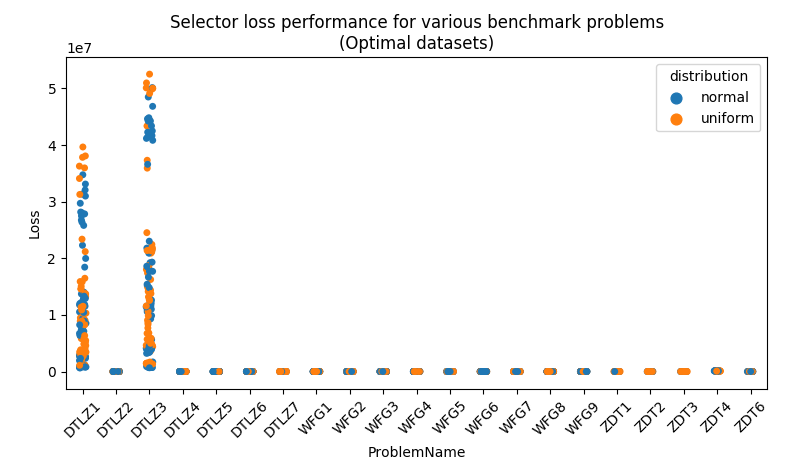

Text(55.847222222222214, 0.5, 'Loss')

In [124]:
sns.stripplot(x='ProblemName',
              y='Prediction',
              hue='distribution',
              order=np.sort(performance["ProblemName"].unique()),
              data=performance)
#sns.boxplot(x='ProblemName', y='CVmean', data=CV_data[CV_data['distribution']=='uniform'])
#sns.catplot(x='ProblemName', y='CVmean',row='distribution', kind='box', data=CV_data)
plt.xticks(rotation=45)
plt.title('Selector loss performance for various benchmark problems\n(Optimal datasets)')
plt.tight_layout()
plt.ylabel("Loss")
#plt.ylim([0, 10e3])

<IPython.core.display.Javascript object>


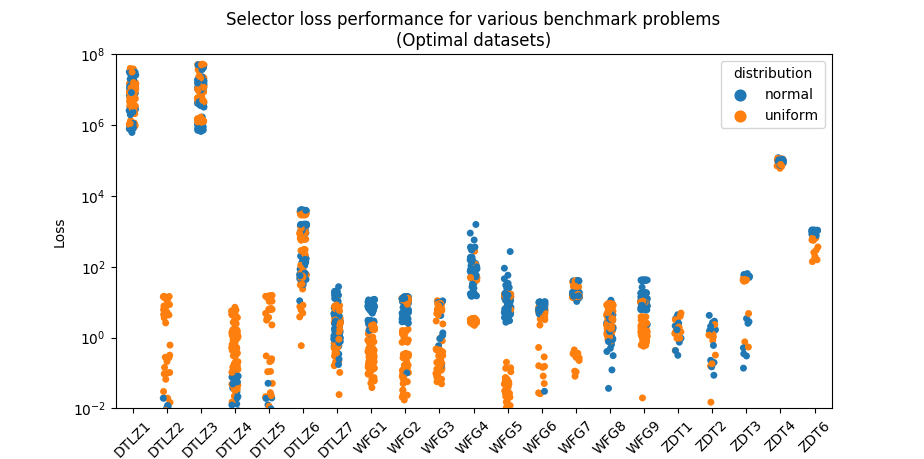

(0.01, 100000000.0)

In [125]:
ax = sns.stripplot(x='ProblemName',
              y='Prediction',
              hue='distribution',
              order=np.sort(performance["ProblemName"].unique()),
              data=performance)
#sns.boxplot(x='ProblemName', y='CVmean', data=CV_data[CV_data['distribution']=='uniform'])
#sns.catplot(x='ProblemName', y='CVmean',row='distribution', kind='box', data=CV_data)
plt.xticks(rotation=45)
plt.title('Selector loss performance for various benchmark problems\n(Optimal datasets)')
#plt.tight_layout()
ax.set(yscale='log')
plt.ylabel("Loss")
plt.ylim([0.01, 10e7])

<IPython.core.display.Javascript object>


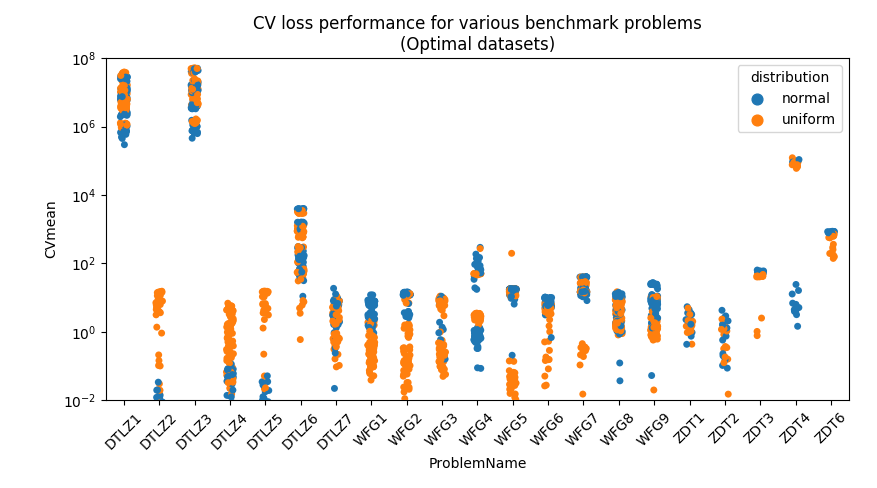

In [126]:
ax1 = sns.stripplot(x='ProblemName',
              y='CVmean',
              hue='distribution',
              order=np.sort(performance["ProblemName"].unique()),
              data=performance)
#sns.boxplot(x='ProblemName', y='CVmean', data=CV_data[CV_data['distribution']=='uniform'])
#sns.catplot(x='ProblemName', y='CVmean',row='distribution', kind='box', data=CV_data)
plt.xticks(rotation=45)
plt.title('CV loss performance for various benchmark problems\n(Optimal datasets)')
ax1.set(yscale='log')
plt.ylim([0.01, 10e7])
plt.tight_layout()

<IPython.core.display.Javascript object>


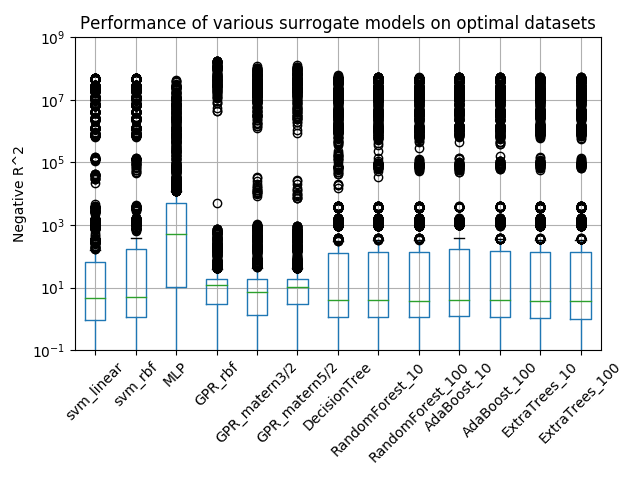

(0.1, 1000000000.0)

In [134]:
ax2 = (-R2_on_optimal).boxplot()
plt.xticks(rotation=45)
plt.ylabel("Negative R^2")
plt.title("Performance of various surrogate models on optimal datasets")
plt.tight_layout()
ax2.set(yscale='log')
plt.ylim([0.1, 10e8])

In [130]:
R2_on_optimal.describe()

,svm_linear,svm_rbf,MLP,GPR_rbf,GPR_matern3/2,GPR_matern5/2,DecisionTree,RandomForest_10,RandomForest_100,AdaBoost_10,AdaBoost_100,ExtraTrees_10,ExtraTrees_100
count,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03,2.714000e+03
mean,-1.556254e+06,-1.559235e+06,-5.773272e+05,-2.630746e+06,-2.287523e+06,-2.172825e+06,-1.707418e+06,-1.698790e+06,-1.689843e+06,-1.728752e+06,-1.697691e+06,-1.731576e+06,-1.735962e+06
std,6.354855e+06,6.364145e+06,3.154716e+06,1.648690e+07,1.073038e+07,1.124609e+07,6.863736e+06,6.835478e+06,6.796690e+06,6.916490e+06,6.825420e+06,6.929674e+06,6.936009e+06
min,-5.184249e+07,-5.154479e+07,-4.307267e+07,-1.806257e+08,-1.182055e+08,-1.306120e+08,-6.136368e+07,-5.431853e+07,-5.229169e+07,-5.332469e+07,-5.370783e+07,-5.237158e+07,-5.258697e+07
25%,-6.539313e+01,-1.675339e+02,-4.900634e+03,-1.808736e+01,-1.808650e+01,-1.808736e+01,-1.265774e+02,-1.334865e+02,-1.353827e+02,-1.656219e+02,-1.442834e+02,-1.344601e+02,-1.357183e+02
50%,-4.690512e+00,-4.936540e+00,-5.194916e+02,-1.178264e+01,-6.957627e+00,-1.025051e+01,-3.878266e+00,-3.852322e+00,-3.837389e+00,-4.051554e+00,-3.950720e+00,-3.746468e+00,-3.761977e+00
75%,-9.358635e-01,-1.178216e+00,-1.031953e+01,-3.085031e+00,-1.302052e+00,-2.975248e+00,-1.113159e+00,-1.101984e+00,-1.102598e+00,-1.266110e+00,-1.127708e+00,-1.061743e+00,-1.019319e+00
max,9.684676e-01,9.789080e-01,9.779554e-01,1.000000e+00,9.999655e-01,9.999960e-01,9.830774e-01,9.503699e-01,9.395459e-01,9.495398e-01,9.728076e-01,9.857205e-01,9.859677e-01
